<a href="https://colab.research.google.com/github/Kyamzzz/GISMA/blob/main/Customer_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This project focuses on building an unsupervised machine learning pipeline using clustering algorithms. The goal of this project is to group customers based on credit card data, enabling businesses to gain valuable insights and make informed decisions.

In a business context, this project holds immense significance. By utilizing clustering algorithms, we can identify distinct customer segments within the dataset. This segmentation allows businesses to understand their customer base better, tailor marketing strategies, and offer personalized products and services. It provides an opportunity to enhance customer satisfaction, improve customer retention, and drive business growth.

Moreover, the project incorporates various stages, including data preprocessing, algorithm selection, hyperparameter tuning, and evaluation. Through exploratory data analysis and data cleaning, I tried to ensure the dataset's quality and optimize the clustering results. The evaluation of different algorithms and tuning of hyperparameters ensure that we achieve the most accurate and meaningful clusters.

Overall, this project equips businesses with powerful analytical tools to uncover patterns and hidden insights within their credit card data. By leveraging the information obtained from clustering, businesses can make data-driven decisions, enhance their competitiveness, and provide enhanced customer experiences. I have donloaded the data from Kaggle for the below link:

Link: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

## Importing Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch, DBSCAN
from itertools import product
import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
%matplotlib inline

## Uploding the Dataset

In [ ]:
df = pd.read_csv('CC.csv') # Uploading the dataset from local drive
df.head() # Shows the columns and the first 5 rows of the dataset

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Exploratory Data Analysis

In [ ]:
dtypes = pd.DataFrame(df.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=df.nunique()
dtypes["Null Values"]=df.isnull().sum()
dtypes["% null Values"]=df.isnull().sum()/len(df)
dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

,Data Type,Unique Values,Null Values,% null Values
MINIMUM_PAYMENTS,float64,8636,313,0.034972
CREDIT_LIMIT,float64,205,1,0.000112
CUST_ID,object,8950,0,0.000000
BALANCE,float64,8871,0,0.000000
PRC_FULL_PAYMENT,float64,47,0,0.000000
PAYMENTS,float64,8711,0,0.000000
PURCHASES_TRX,int64,173,0,0.000000
CASH_ADVANCE_TRX,int64,65,0,0.000000
CASH_ADVANCE_FREQUENCY,float64,54,0,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,float64,47,0,0.000000


### Dropping 'CUST_ID' column as it is object type and is not necessary for the analysis.

In [ ]:
df = df.drop('CUST_ID',axis = 1)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Applying KNN Imputer - The K-Nearest Neighbors (KNN) Imputer will impute the missing values in our dataset based on the values of its nearest neighbors.

In [ ]:
from sklearn.impute import KNNImputer
nullcolumns = df.columns[df.isnull().any()].to_list()
imputer = KNNImputer()
df_imp = pd.DataFrame(imputer.fit_transform(df[nullcolumns]),columns = nullcolumns)
df = df.fillna(df_imp)

### Checking if the null values have been imputed

In [ ]:
df.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

### Corelation Analysis

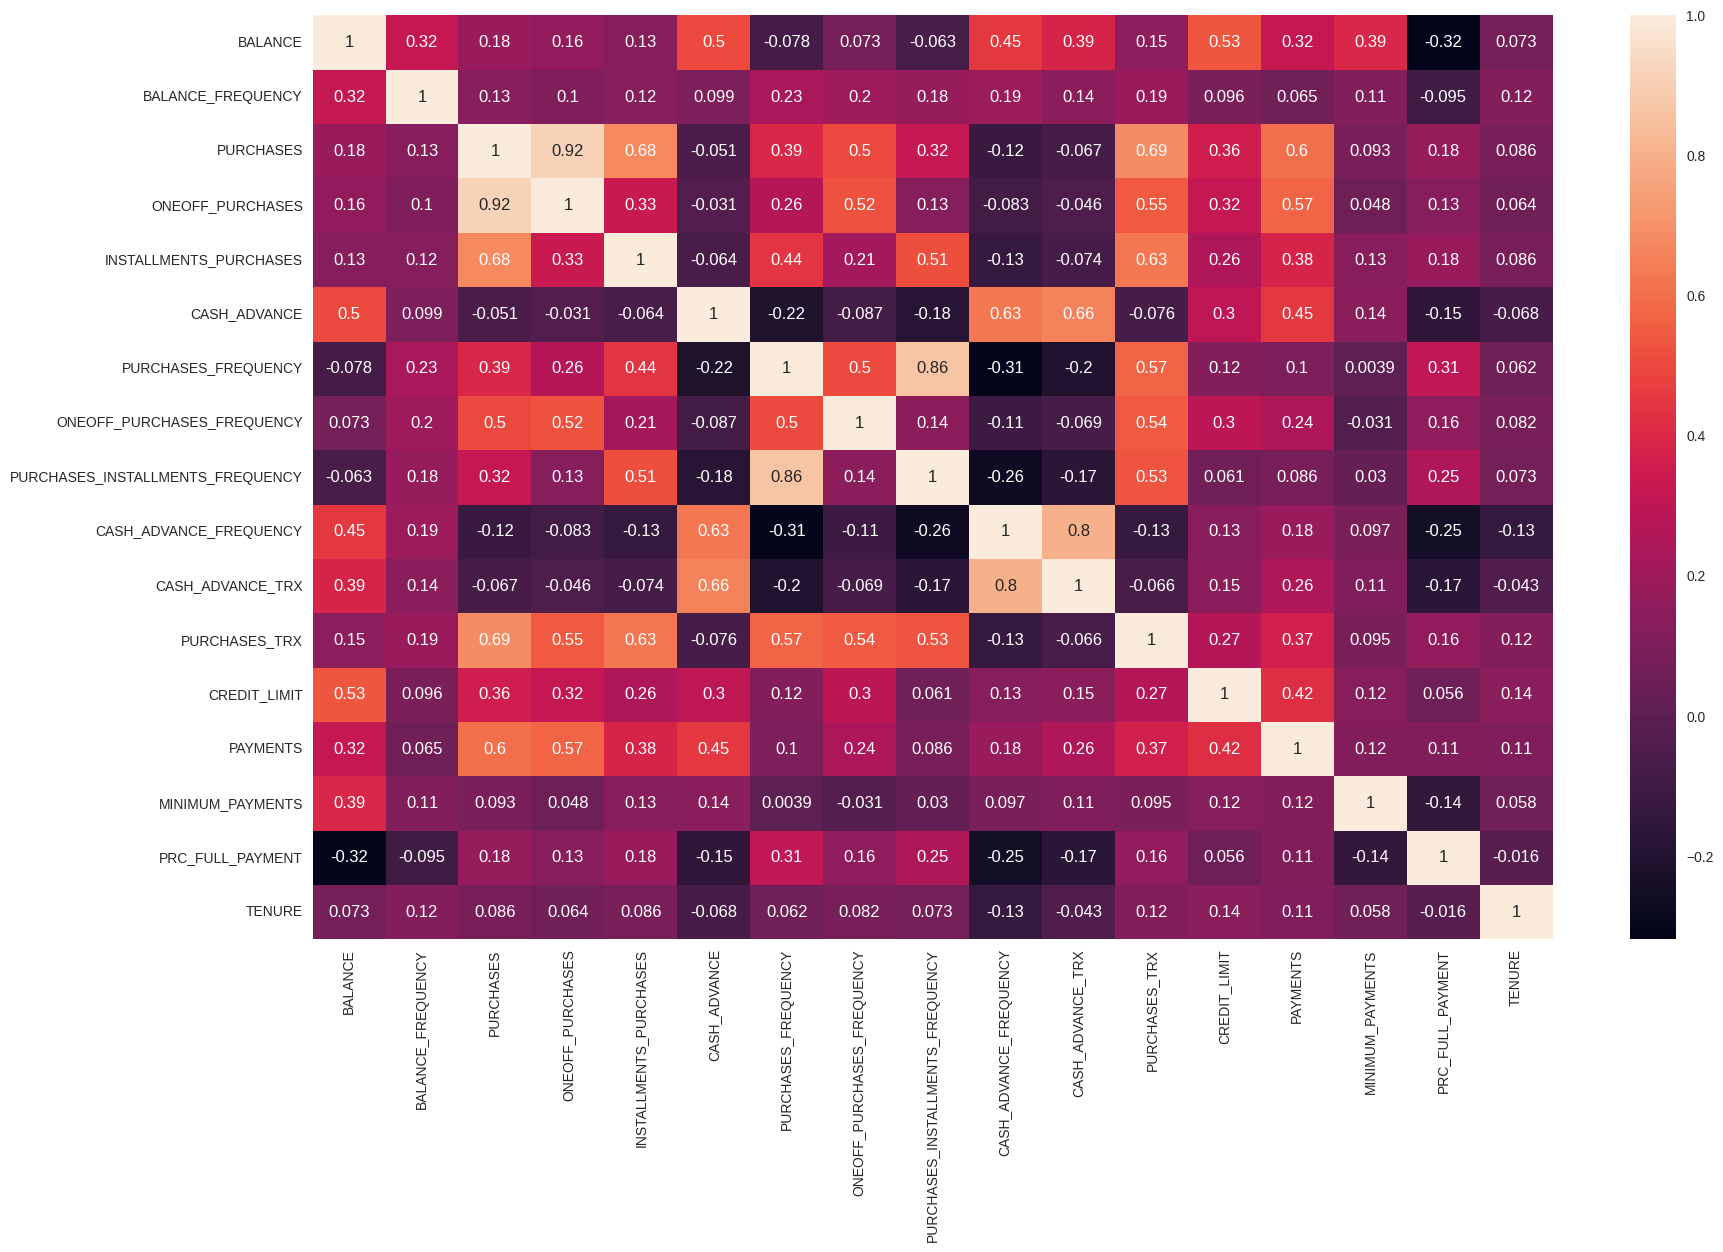

In [ ]:
plt.subplots(figsize = (20,12))
sns.heatmap(df.corr(),annot = True)
plt.show()

### Plotting the relation between Purchases and Maximum amount of purchase in one go

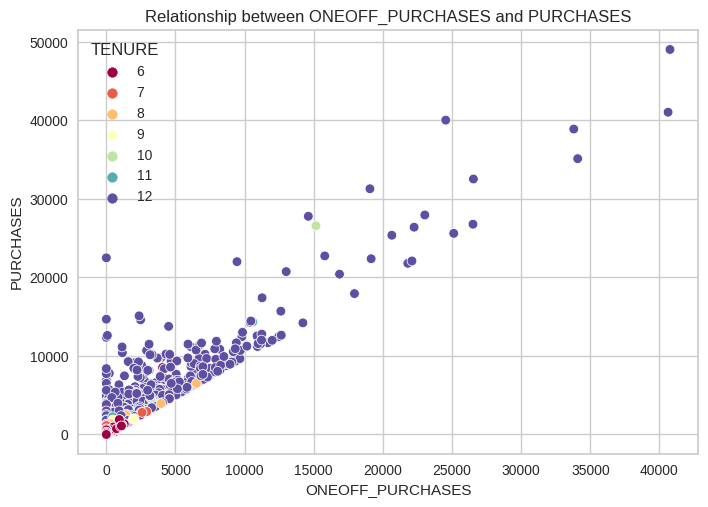

In [ ]:
sns.scatterplot(data=df, x='ONEOFF_PURCHASES', y='PURCHASES', hue='TENURE', palette='Spectral')
plt.xlabel('ONEOFF_PURCHASES')
plt.ylabel('PURCHASES')
plt.title('Relationship between ONEOFF_PURCHASES and PURCHASES')
plt.show()

## Data Pre-Processing

Scaling the Data


In [ ]:
Scaler = StandardScaler()
df_scaled = Scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960383,-0.528979,-0.311729,-0.525551,0.360680
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688676,0.818642,0.087047,0.234227,0.360680
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826098,-0.383805,-0.103210,-0.525551,0.360680
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826098,-0.598688,0.148440,-0.525551,0.360680
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905414,-0.364368,-0.266722,-0.525551,0.360680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.737950,0.518084,-0.333293,-0.356934,-0.132643,-0.466786,1.269843,-0.678661,1.179833,-0.675349,-0.476070,-0.350408,-0.960383,-0.486217,-0.350470,1.183951,-4.122768
8946,-0.742423,0.518084,-0.329136,-0.356934,-0.122823,-0.466786,1.269843,-0.678661,1.179833,-0.675349,-0.476070,-0.350408,-0.960383,-0.503396,1.219059,-0.525551,-4.122768
8947,-0.740398,-0.185477,-0.401965,-0.356934,-0.294893,-0.466786,0.854576,-0.678661,0.760469,-0.675349,-0.476070,-0.390639,-0.960383,-0.570615,-0.336135,0.329200,-4.122768
8948,-0.745174,-0.185477,-0.469552,-0.356934,-0.454576,-0.449352,-1.221758,-0.678661,-0.916995,0.157527,-0.182998,-0.591796,-1.097804,-0.580536,-0.347533,0.329200,-4.122768


Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
df_scaled = pca.fit_transform(df_scaled)

### Visualizing the number of possible clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

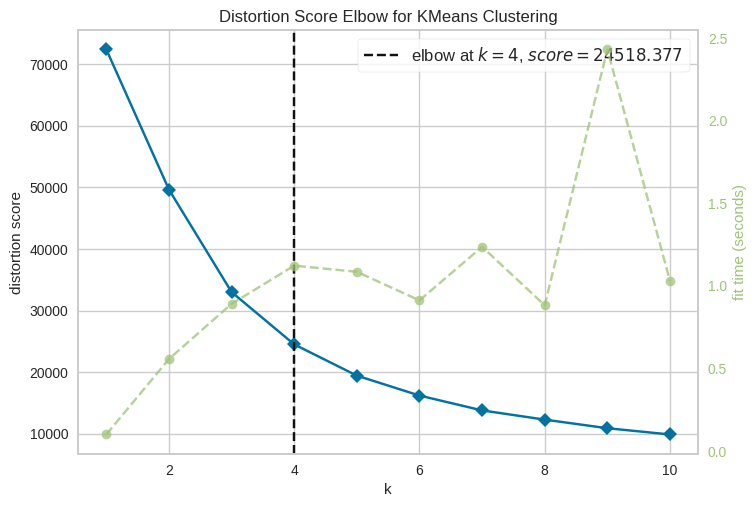

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k =(1,11))
visualizer.fit(df_scaled)
visualizer.show()
plt.show()

### Fitting k=4 clusters in the model

In [ ]:
kmeans = KMeans(n_clusters = 4,random_state = 24, max_iter = 1000)
y_means = kmeans.fit_predict(df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Calculating the Silhoutte Score

In [ ]:
from sklearn import metrics
metrics.silhouette_score(df_scaled,y_means)

0.4076610976494298

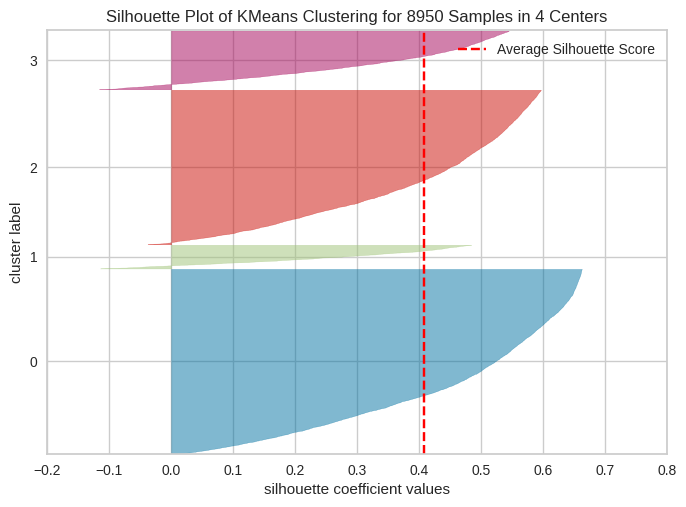

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(df_scaled)
visualizer.show()
plt.show()

### Finding the Centroid of the clusters

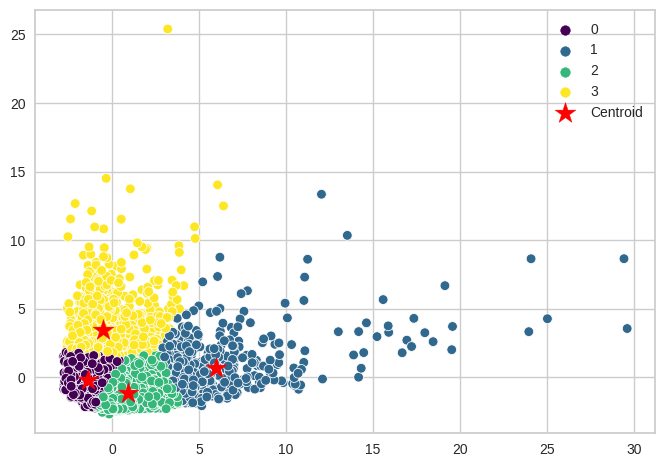

In [ ]:
centroid = kmeans.cluster_centers_
sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=y_means, palette='viridis')
centroid_plot = plt.scatter(x=centroid[:, 0], y=centroid[:, 1], c='red', s=250, marker='*', label='Centroid')
plt.legend()
plt.show()

### Cluster Attributes

In [ ]:
df["cluster"] = y_means
df.groupby("cluster").describe()

BALANCE                                                    \
          count         mean          std        min          25%   
cluster                                                             
0        3918.0  1012.915503  1072.288682   0.000000    88.595906   
1         503.0  3401.840056  3243.214980  21.311946   814.975228   
2        3284.0   824.180354  1139.569873   0.000000    73.833592   
3        1245.0  4510.612798  2723.982121   4.382924  2437.750644   

                                                BALANCE_FREQUENCY            \
                 50%          75%           max             count      mean   
cluster                                                                       
0         803.043054  1496.478741   8115.039014            3918.0  0.799792   
1        2422.311938  5049.916832  19043.138560             503.0  0.988427   
2         286.957075  1177.395882   7789.190958            3284.0  0.919997   
3        4175.826879  6045.192228  16304.889250            1245.0  0.963486   

         ... PRC_FULL_PAYMENT       TENURE                                  \
         ...              75%  max   count       mean       std  min   25%   
cluster  ...                                                                 
0        ...         0.000000  1.0  3918.0  11.364216  1.520791  6.0  12.0   
1        ...         0.666667  1.0   503.0  11.960239  0.407120  6.0  12.0   
2        ...         0.545455  1.0  3284.0  11.661693  1.129606  6.0  12.0   
3        ...         0.000000  1.0  1245.0  11.439357  1.397825  6.0  12.0   

                           
          50%   75%   max  
cluster                    
0        12.0  12.0  12.0  
1        12.0  12.0  12.0  
2        12.0  12.0  12.0  
3        12.0  12.0  12.0  

[4 rows x 136 columns]

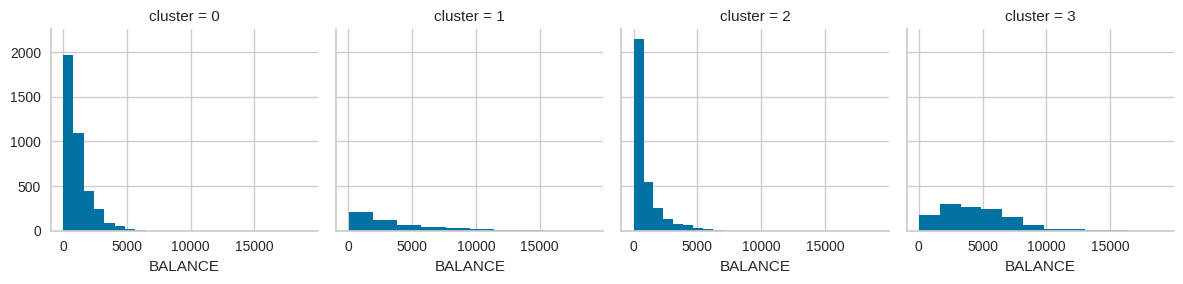

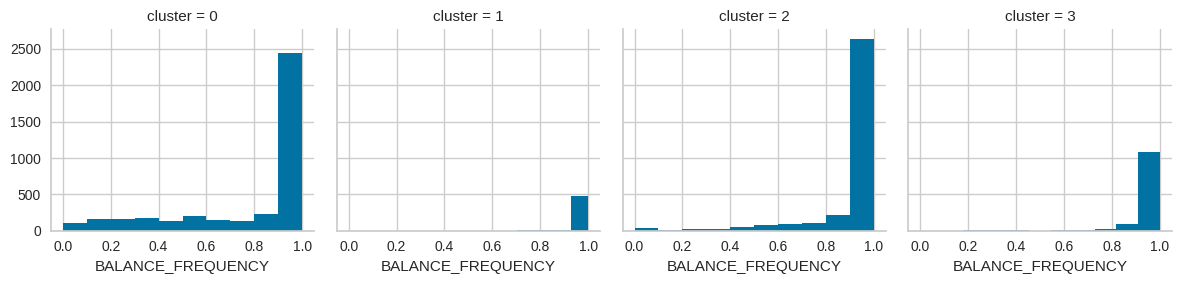

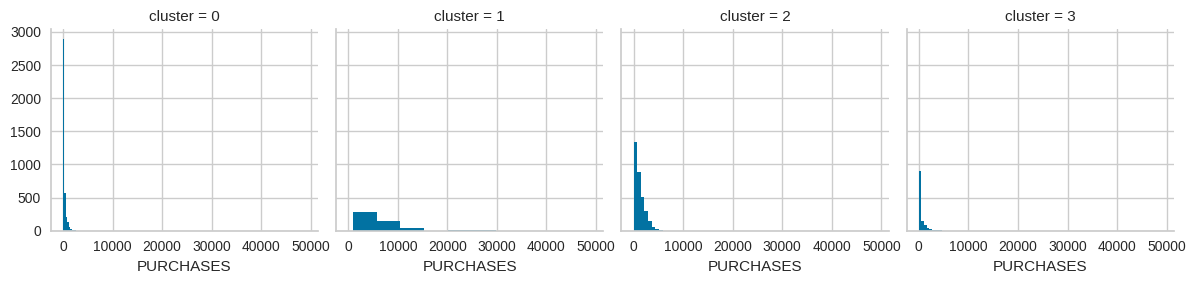

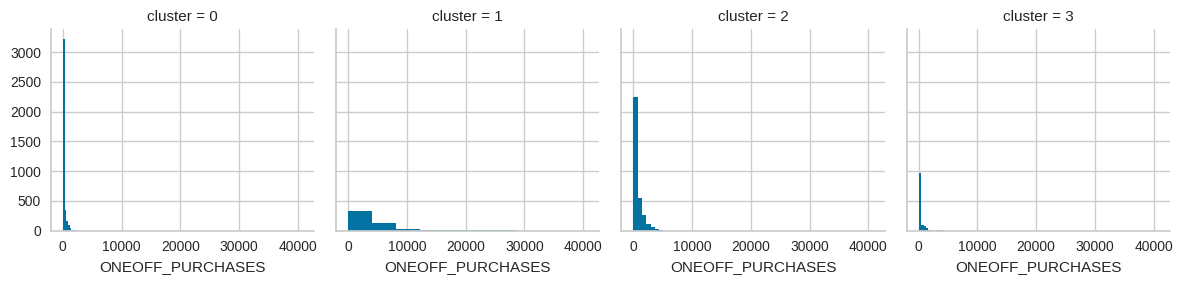

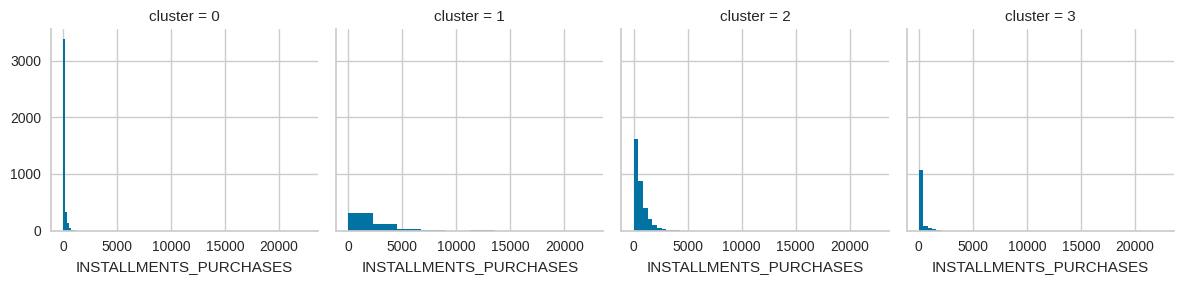

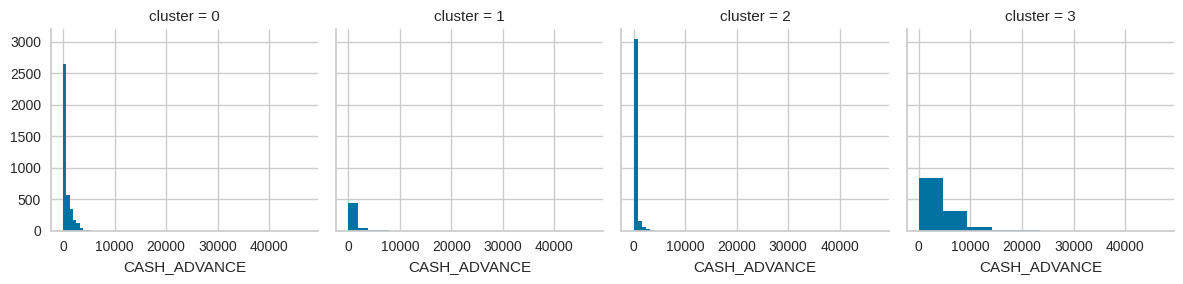

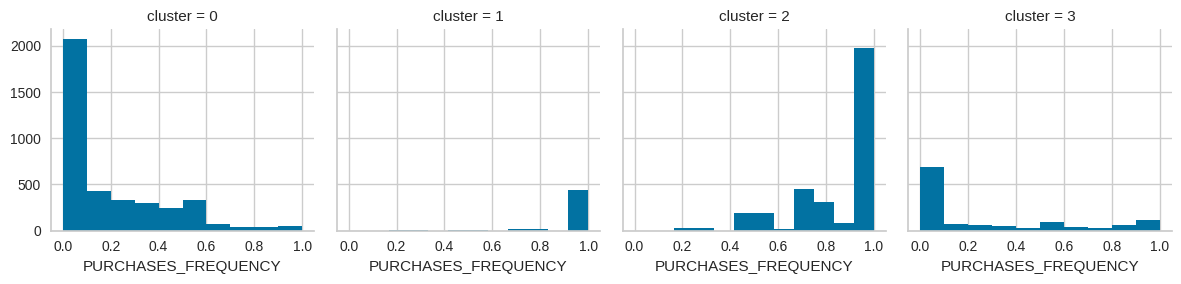

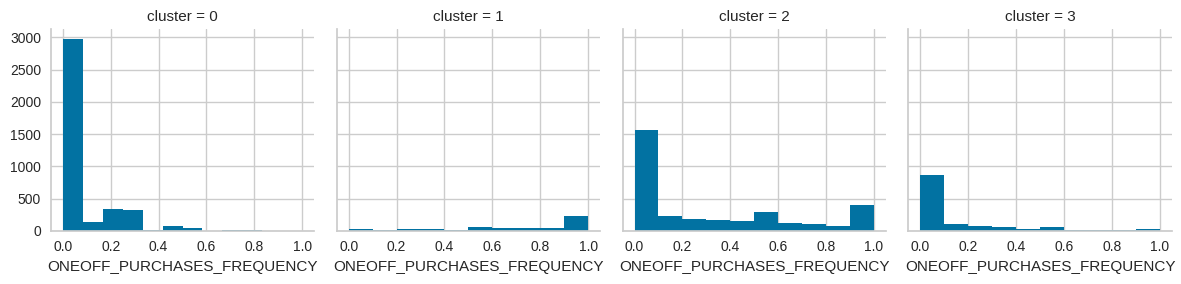

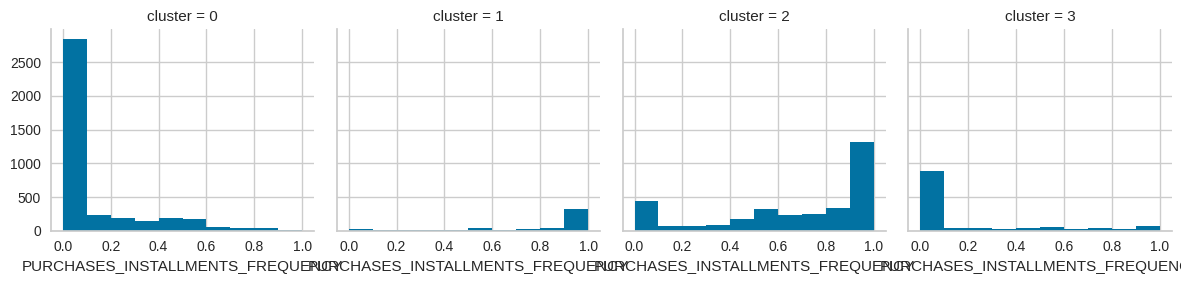

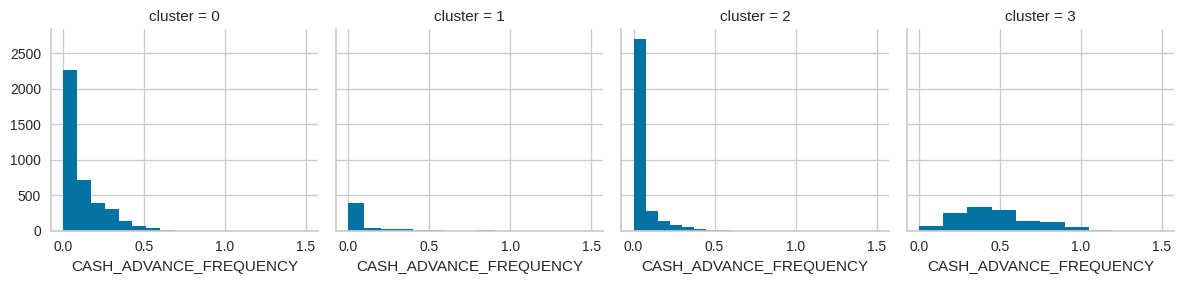

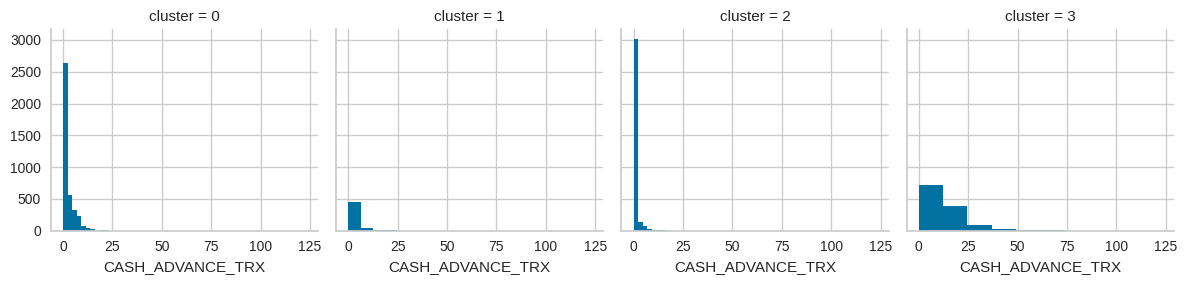

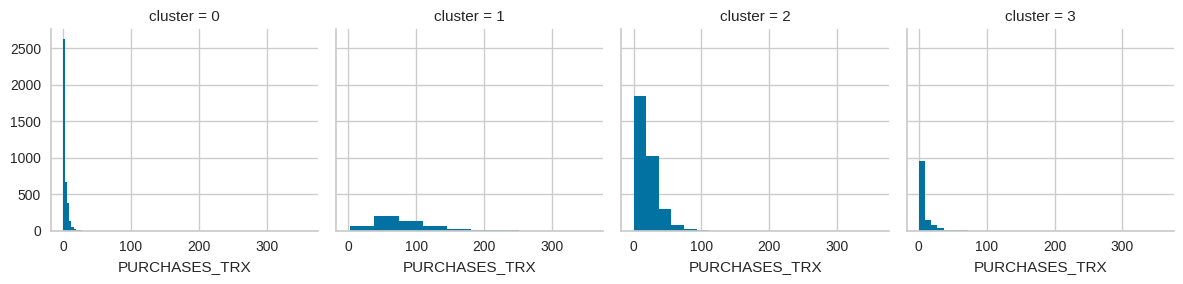

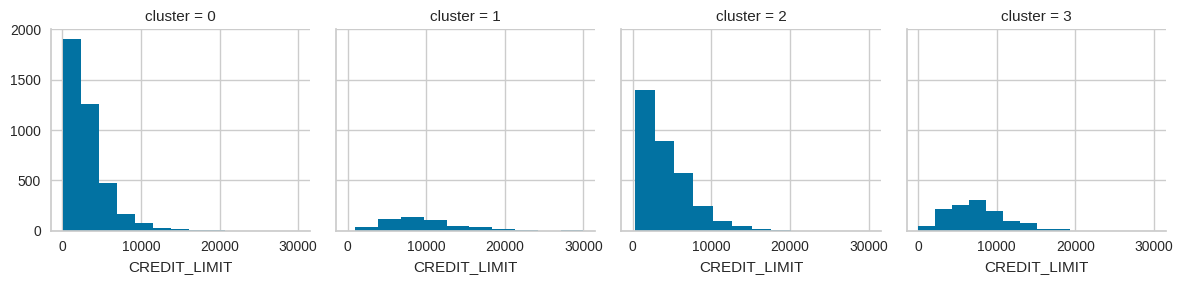

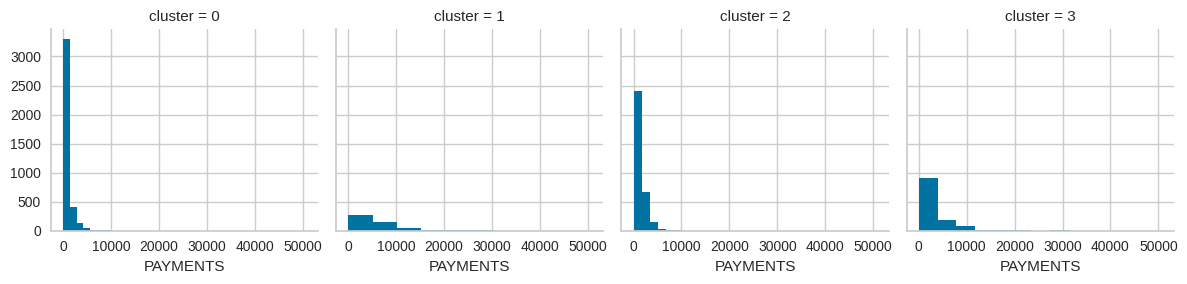

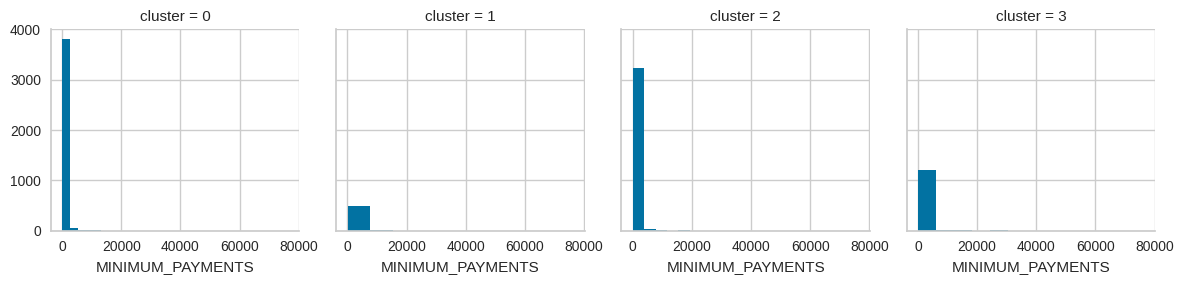

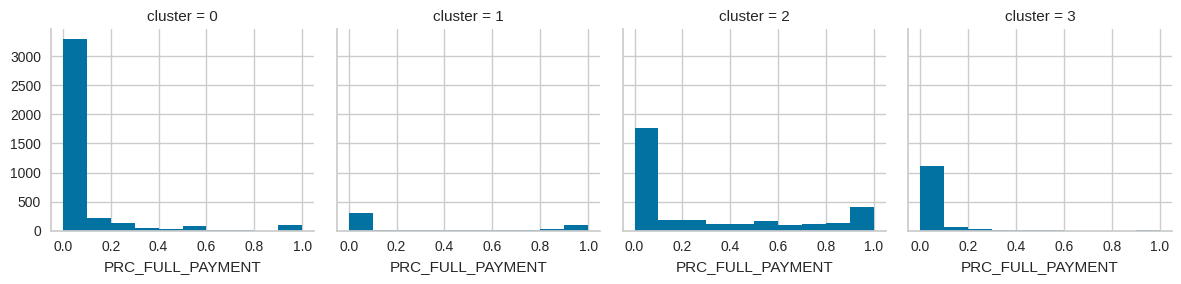

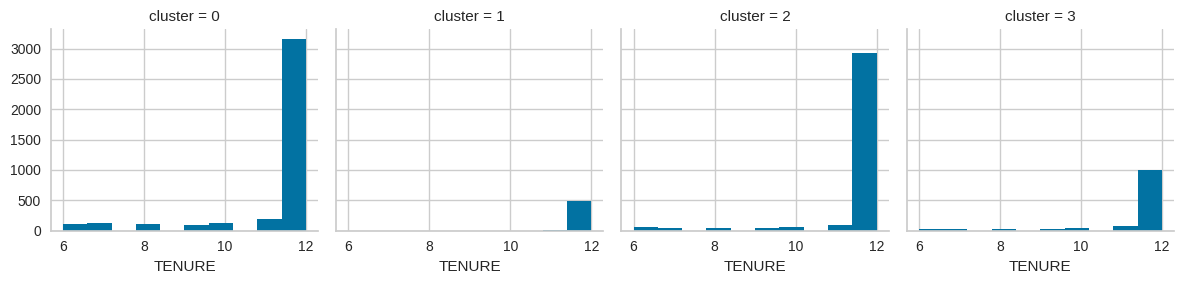

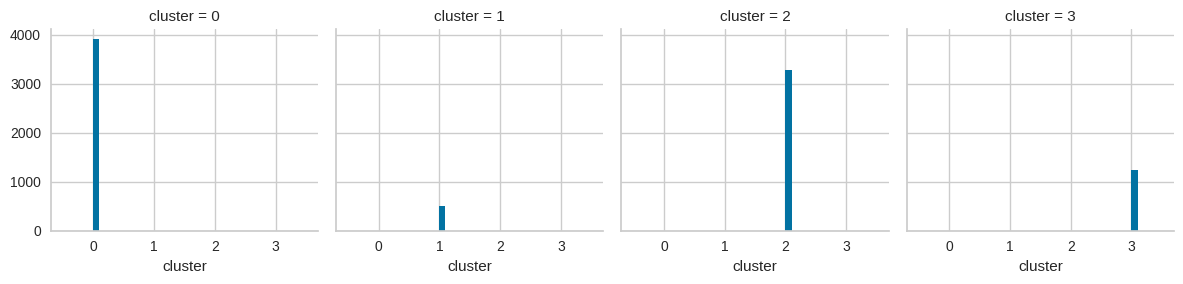

In [ ]:
for c in df:
    grid= sns.FacetGrid(df, col='cluster')
    grid.map(plt.hist, c)

### Applying DBSCAN Algorithm

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(df_scaled)

DBSCAN(min_samples=10)

In [ ]:
## Extracting cluster labels
labels_dbscan = dbscan.labels_

In [ ]:
## Calculating the Silhouette Score for DBSCAN
silhouette_score_dbscan = metrics.silhouette_score(df_scaled, labels_dbscan)
print(f"DBSCAN Silhouette Score: {silhouette_score_dbscan}")

DBSCAN Silhouette Score: 0.39219079453098155


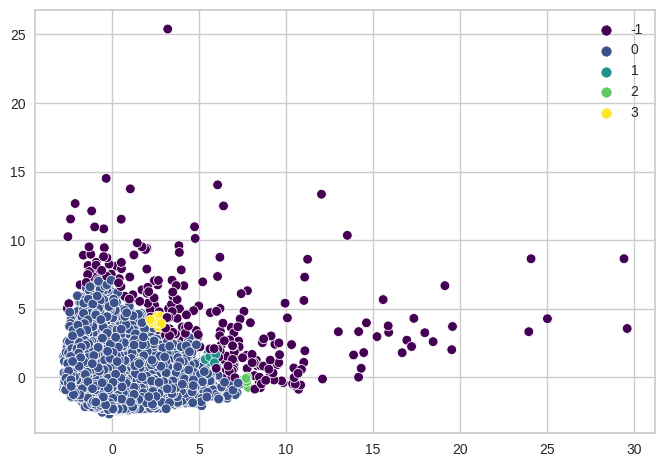

In [ ]:
## Visualize the DBSCAN clusters
sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=labels_dbscan, palette='viridis')
plt.show()

In [ ]:
df["cluster_dbscan"] = labels_dbscan
df.groupby("cluster_dbscan").describe()

BALANCE                                                      \
                 count         mean          std          min          25%   
cluster_dbscan                                                               
-1               238.0  6048.245440  3976.571596   269.075434  2886.440155   
 0              8681.0  1427.841404  1835.010095     0.000000   119.237712   
 1                14.0  7072.497005  3027.271340   868.044414  5541.974227   
 2                 8.0  1536.469162  1159.709391   772.546910   829.015666   
 3                 9.0  6241.039729  3561.429731  2283.366217  3800.151377   

                                                       BALANCE_FREQUENCY  \
                        50%          75%           max             count   
cluster_dbscan                                                             
-1              5279.334514  8302.127007  19043.138560             238.0   
 0               821.916526  1906.703614  14224.115410            8681.0   
 1              7982.659735  9026.735933  10599.442300              14.0   
 2              1001.928940  1605.549395   3746.919031               8.0   
 3              5066.461251  8073.983031  13318.659120               9.0   

                          ... TENURE       cluster                           \
                    mean  ...    75%   max   count      mean       std  min   
cluster_dbscan            ...                                                 
-1              0.980979  ...   12.0  12.0   238.0  1.806723  0.983212  1.0   
 0              0.874022  ...   12.0  12.0  8681.0  1.189609  1.148527  0.0   
 1              1.000000  ...   12.0  12.0    14.0  1.000000  0.000000  1.0   
 2              1.000000  ...   12.0  12.0     8.0  1.000000  0.000000  1.0   
 3              0.968687  ...   12.0  12.0     9.0  3.000000  0.000000  3.0   

                                    
                25%  50%  75%  max  
cluster_dbscan                      
-1              1.0  1.0  3.0  3.0  
 0              0.0  2.0  2.0  3.0  
 1              1.0  1.0  1.0  1.0  
 2              1.0  1.0  1.0  1.0  
 3              3.0  3.0  3.0  3.0  

[5 rows x 144 columns]

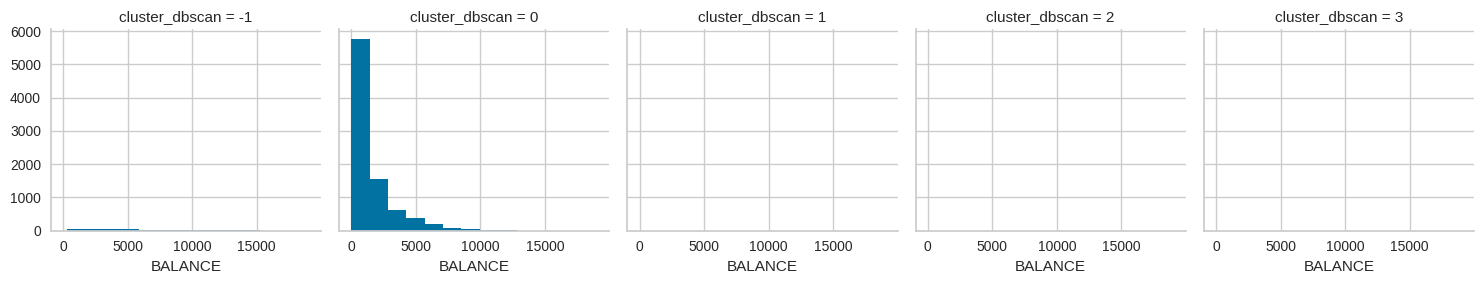

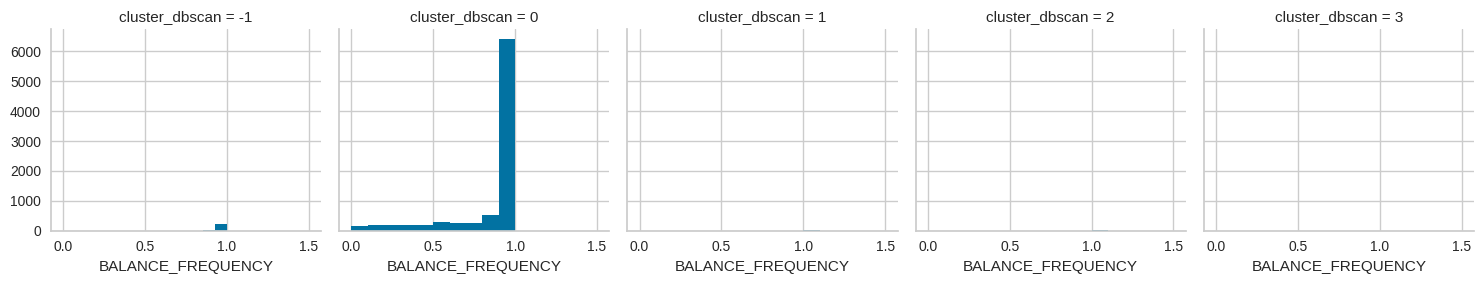

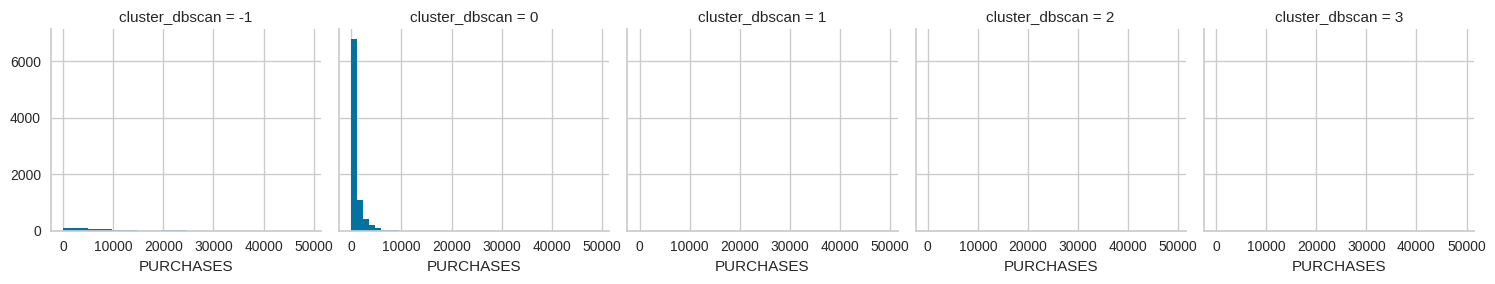

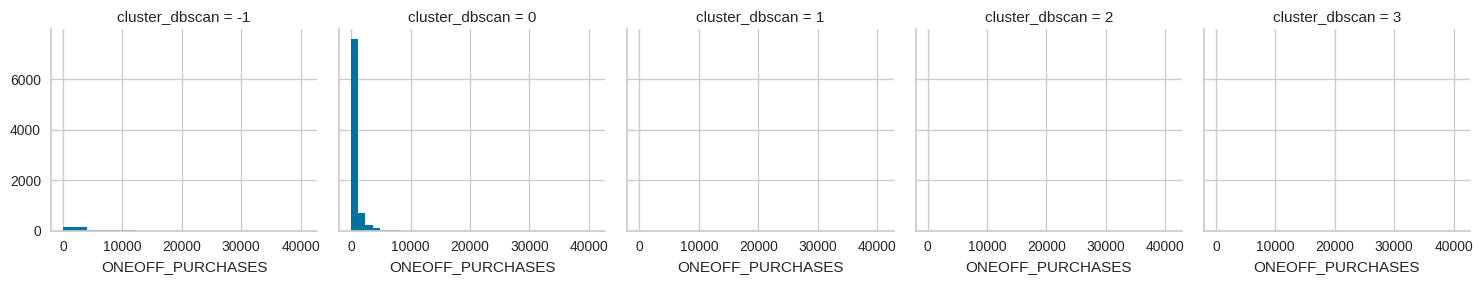

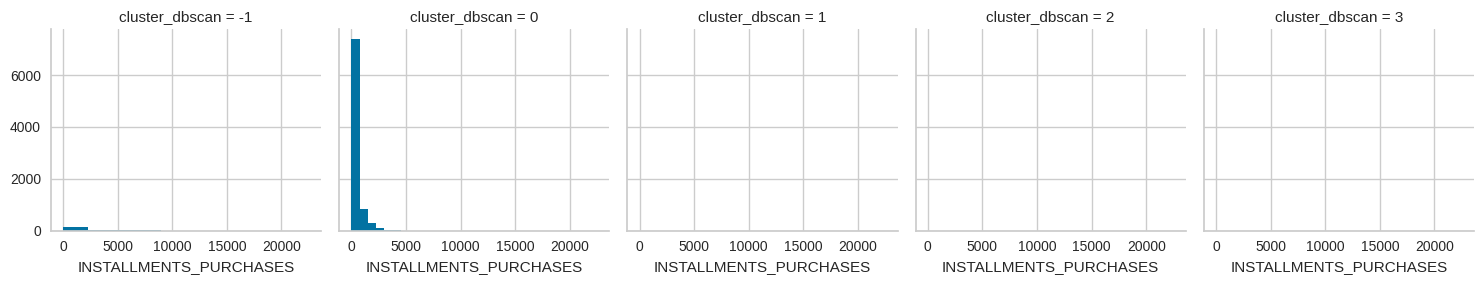

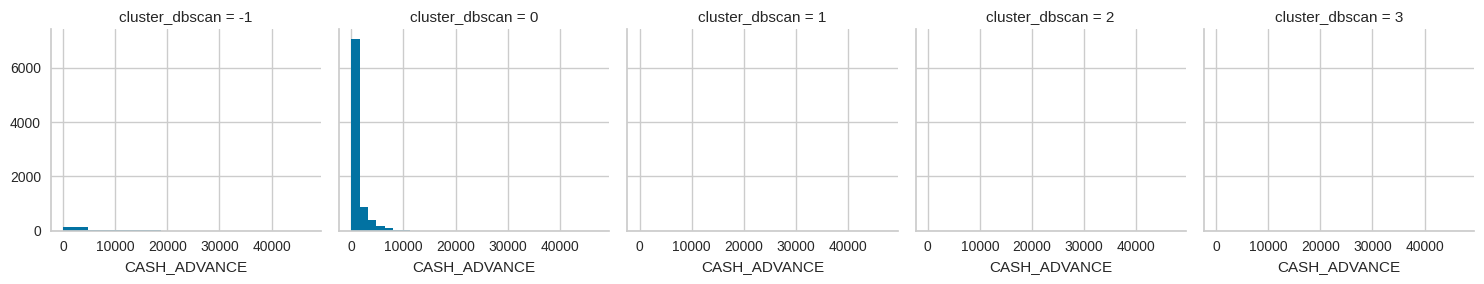

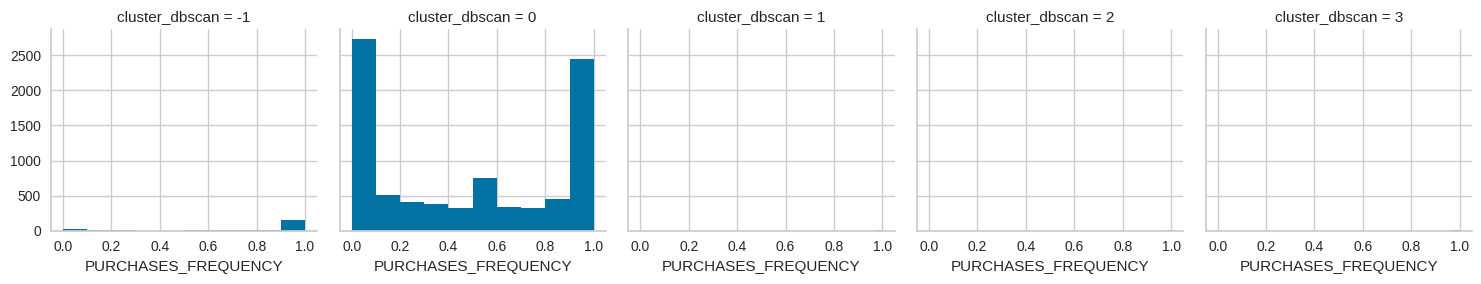

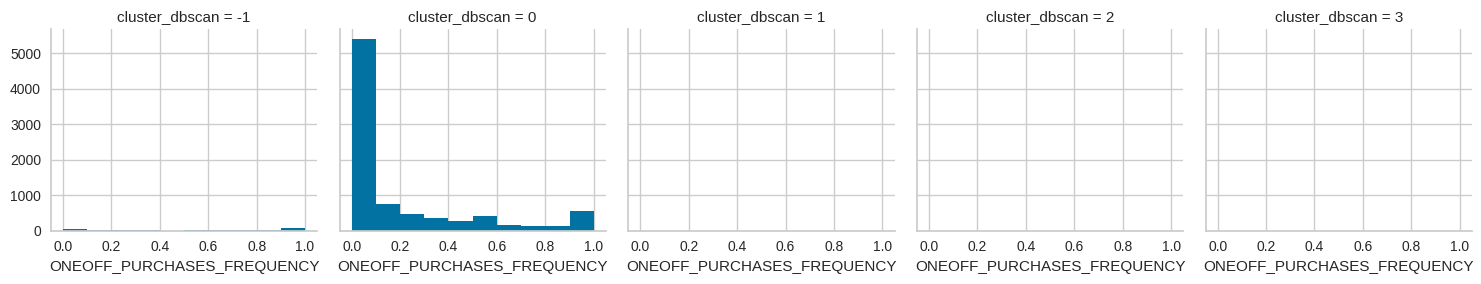

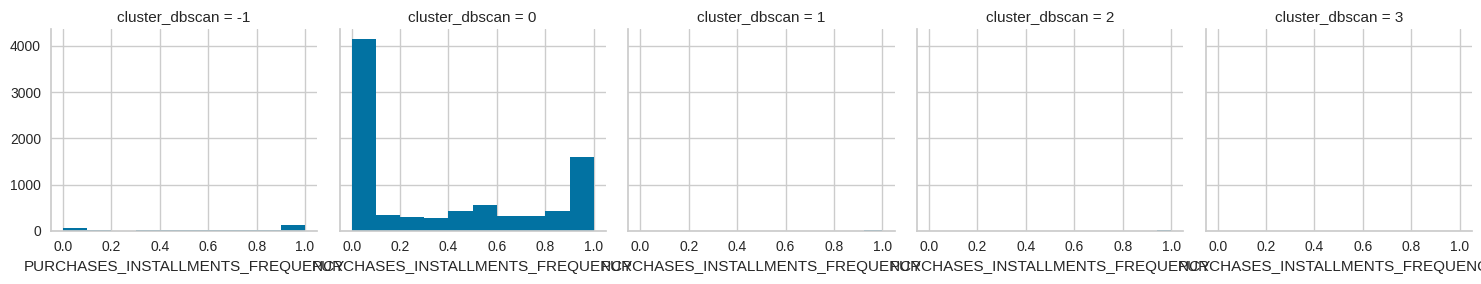

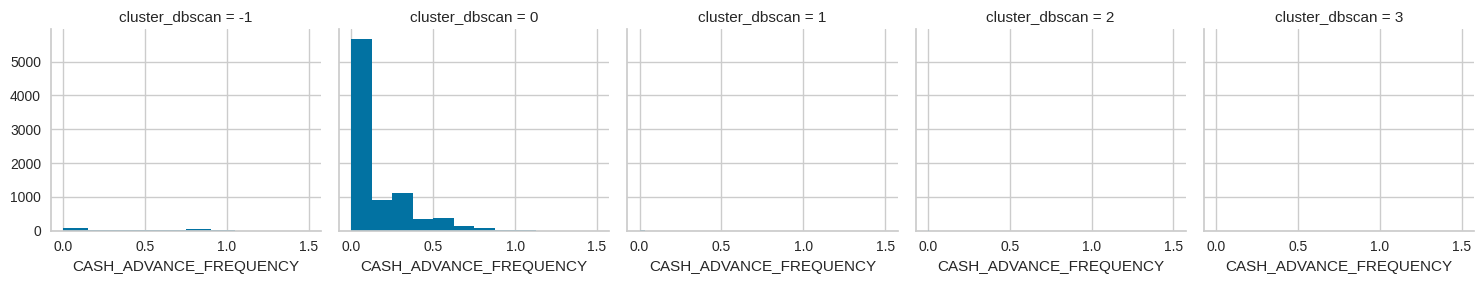

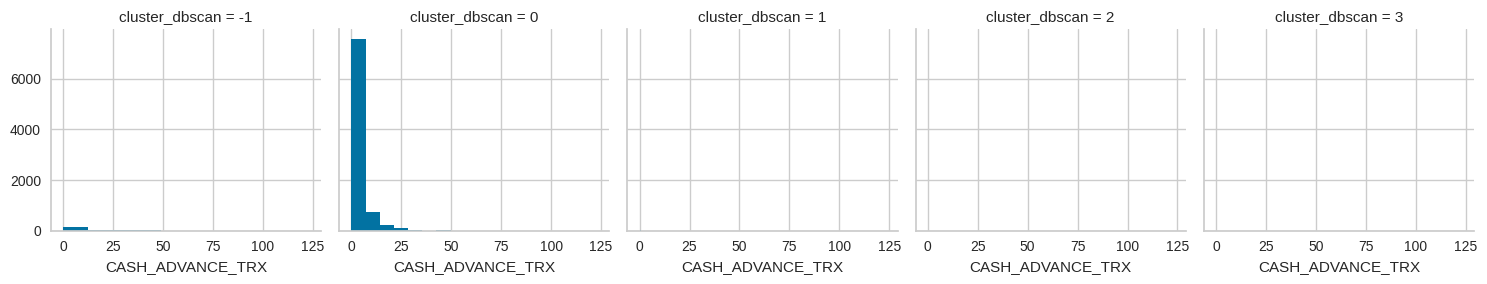

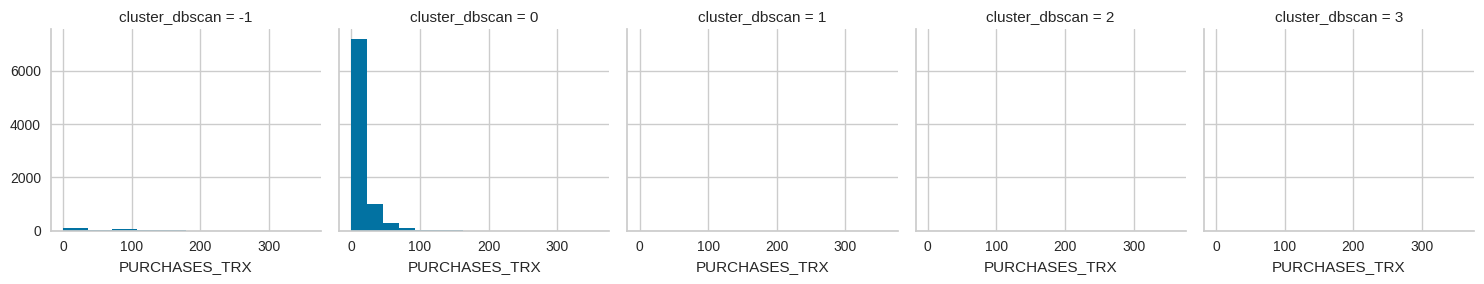

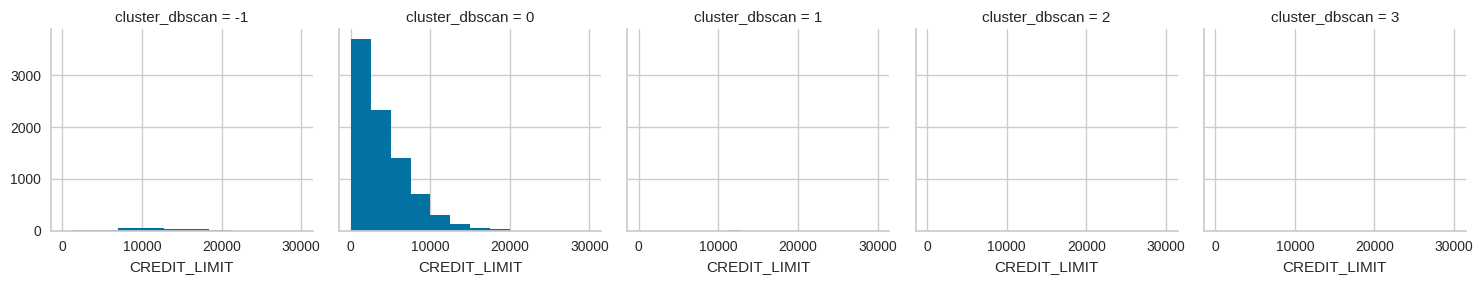

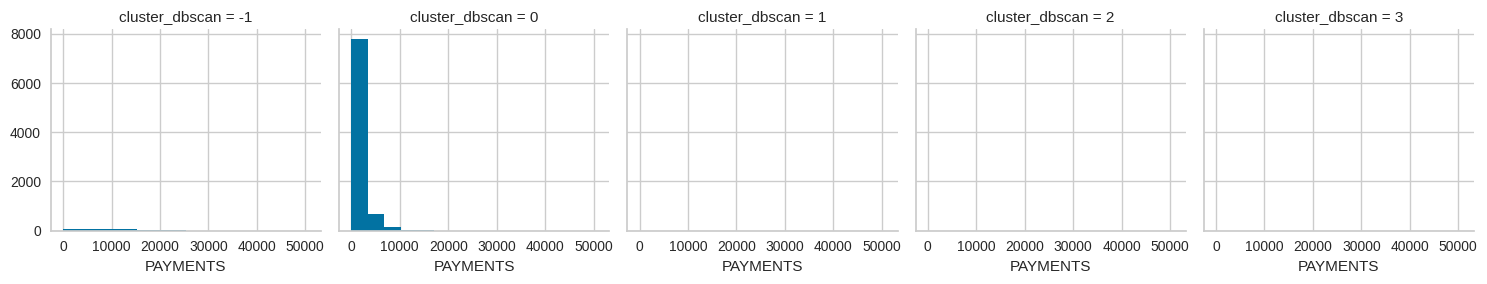

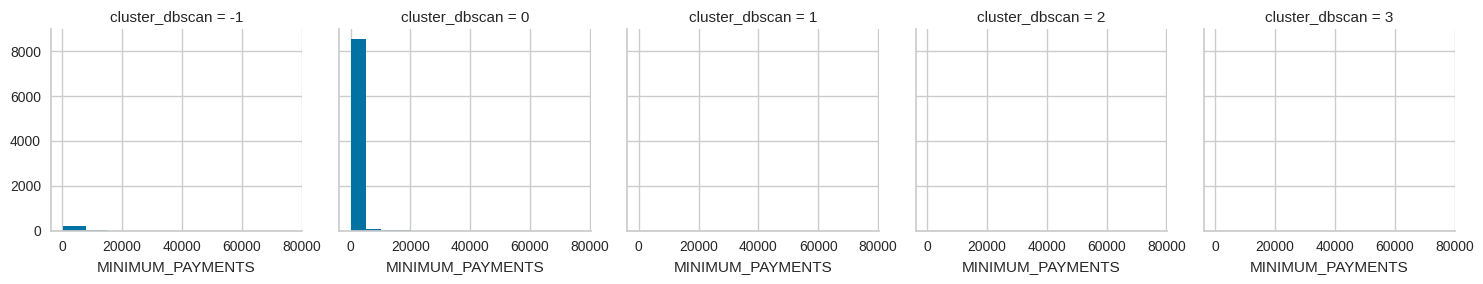

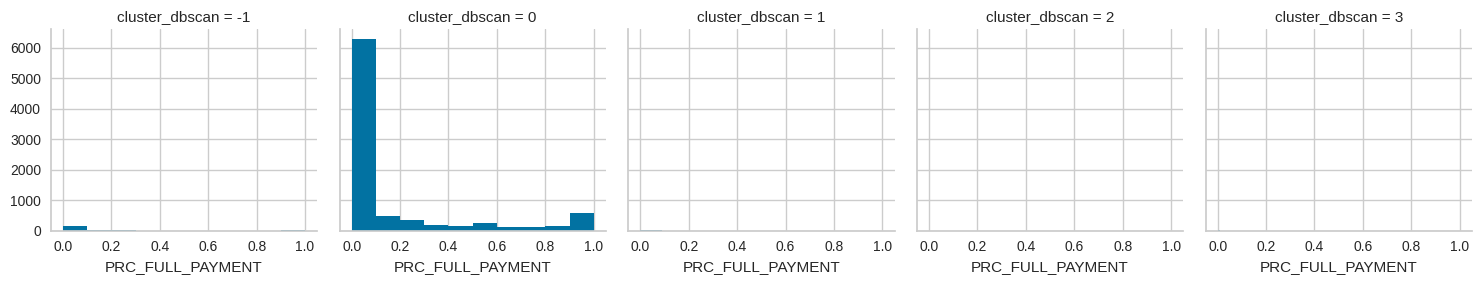

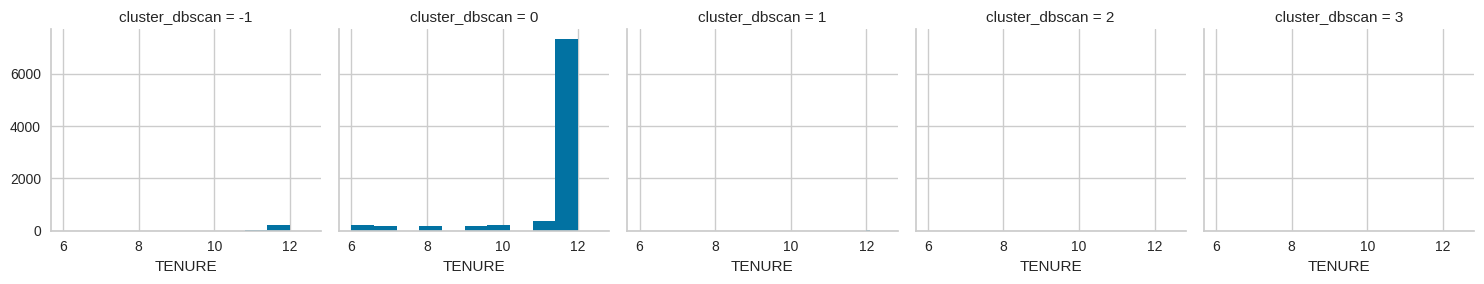

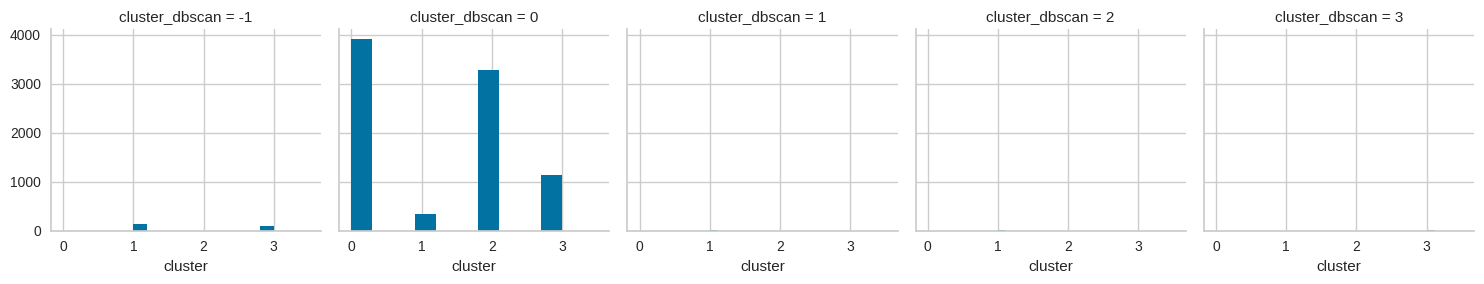

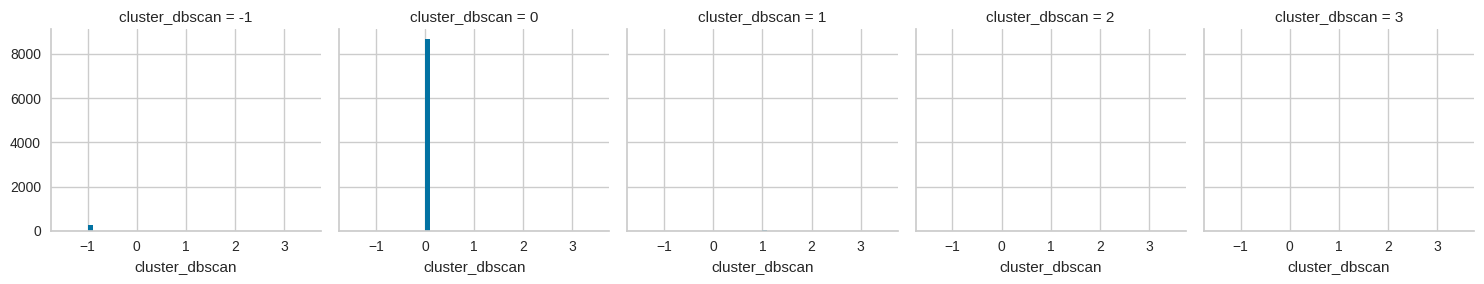

In [ ]:
for c in df:
    grid = sns.FacetGrid(df, col='cluster_dbscan')
    grid.map(plt.hist, c)
    plt.show()

### Hyperparameter Tuning for K-Means and DBSCAN

In [ ]:
# Creating a pipeline for K-means
pipeline_kmeans = Pipeline([('kmeans', KMeans(init='k-means++', n_init=10, random_state=0))])

# Creating a parameter grid for K-means
param_grid_kmeans = {'kmeans__n_clusters': range(2, 10)}

# Performing grid search for K-means
grid_kmeans = GridSearchCV(pipeline_kmeans, param_grid_kmeans, cv=5)
grid_kmeans.fit(df_scaled)

# Printing the best parameters for K-means
print('Best parameters for K-means: ', grid_kmeans.best_params_)

Best parameters for K-means:  {'kmeans__n_clusters': 9}


In [ ]:
# Fitting the best K-means model obtained from hyperparameter tuning
best_kmeans_model = grid_kmeans.best_estimator_
best_kmeans_model.fit(df_scaled)

# Predicting the cluster labels
kmeans_labels = best_kmeans_model.predict(df_scaled)

# Calculating the silhouette score
kmeans_score = silhouette_score(df_scaled, kmeans_labels)

# Printing the silhouette score for K-means
print('Silhouette score for K-means: ', kmeans_score)


Silhouette score for K-means:  0.370751377360667


In [ ]:
# Creating a pipeline for DBSCAN
pipeline_dbscan = Pipeline([('dbscan', DBSCAN())])

# Creating a parameter grid for DBSCAN
param_grid_dbscan = {'dbscan__eps': [0.3, 0.5, 0.7], 'dbscan__min_samples': [3, 5, 7]}

# Performing grid search for DBSCAN with the custom scoring function
grid_dbscan = GridSearchCV(pipeline_dbscan, param_grid_dbscan, cv=5, scoring=silhouette_scorer)
grid_dbscan.fit(df_scaled)

# Printing the best parameters for DBSCAN
print('Best parameters for DBSCAN: ', grid_dbscan.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "<ipython-input-38-3b7a35722a92>", line 5, in silhouette_scorer
    labels = estimator.labels_
AttributeError: 'Pipeline' object has no attribute 'labels_'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "<ipython-input-38-3b7a35722a92>", line 

Best parameters for DBSCAN:  {'dbscan__eps': 0.3, 'dbscan__min_samples': 3}


In [ ]:
# Calculating the silhouette score for DBSCAN
dbscan_score = silhouette_scorer(best_dbscan_model['dbscan'], df_scaled)

# Printing the silhouette score for DBSCAN
print('Silhouette score for DBSCAN: ', dbscan_score)

Silhouette score for DBSCAN:  0.3315340625729611


Applying Agglomerative Clustering

In [ ]:
# Assuming you have obtained the optimal number of clusters using K-means
best_k = 9

# Applying Agglomerative Clustering with the optimal number of clusters found for K-means
agglo = AgglomerativeClustering(n_clusters=best_k)
agglo_clusters = agglo.fit_predict(df_scaled)

# Calculating the silhouette score
score_agglo = silhouette_score(df_scaled, agglo_clusters)

# Printing the silhouette score
print('Silhouette score for Agglomerative Clustering: ', score_agglo)


Silhouette score for Agglomerative Clustering:  0.31080650833714146


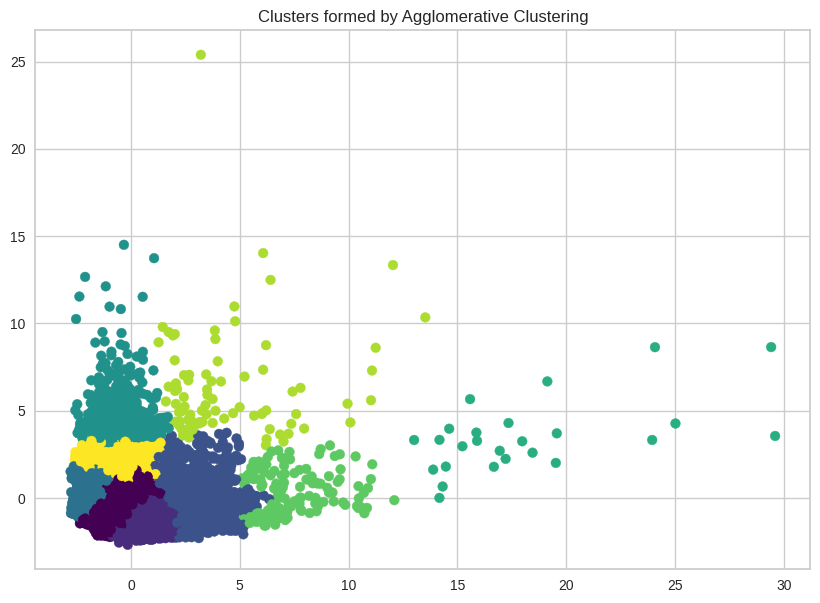

In [ ]:
# Visualizing the clusters formed by Agglomerative Clustering
plt.figure(figsize=(10, 7))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=agglo_clusters, cmap='viridis')
plt.title('Clusters formed by Agglomerative Clustering')
plt.show()

In [ ]:
# Hyperparameter Tuning for Agglomerative Clustering

# Creating a pipeline for Agglomerative Clustering
pipeline_agglo = Pipeline([('agglo', AgglomerativeClustering())])

# Creating a parameter grid for Agglomerative Clustering
param_grid_agglo = {'agglo__n_clusters': range(2, 10)}

# Performing grid search for Agglomerative Clustering with the custom scoring function
grid_agglo = GridSearchCV(pipeline_agglo, param_grid_agglo, cv=5, scoring=silhouette_scorer)
grid_agglo.fit(df_scaled)

# Printing the best parameters for Agglomerative Clustering
print('Best parameters for Agglomerative Clustering: ', grid_agglo.best_params_)

# Fitting the best Agglomerative Clustering model obtained from hyperparameter tuning
best_agglo_model = grid_agglo.best_estimator_
best_agglo_model.fit(df_scaled)

# Predicting the cluster labels
agglo_labels = best_agglo_model.fit_predict(df_scaled)

# Calculating the silhouette score for Agglomerative Clustering
agglo_score = silhouette_score(df_scaled, agglo_labels)

# Print the silhouette score for Agglomerative Clustering
print('Silhouette score for Agglomerative Clustering: ', agglo_score)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "<ipython-input-38-3b7a35722a92>", line 5, in silhouette_scorer
    labels = estimator.labels_
AttributeError: 'Pipeline' object has no attribute 'labels_'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "<ipython-input-38-3b7a35722a92>", line 

Best parameters for Agglomerative Clustering:  {'agglo__n_clusters': 2}
Silhouette score for Agglomerative Clustering:  0.37053350072020674


## Findings and Conclusion

In this project, I worked on a credit card dataset with the aim of clustering the customers into appropriate groups using unsupervised machine learning techniques for clustering. The pipelie followed the similar pattern as learnt throughout the last 2 modules.



1.   Loading the neccessary libraries
2.   Exploratory Data Analysis (EDA)
3.   Data Pre-Processing
4.   Applying K-Means Algorithm
5.   Applying DBSCAN Algorithm
6.   Hyperparameter tuning
7.   Applying Agglomerative Clustering Algorithm

I applied the K-means clustering algorithm to the preprocessed data using the elbow method to find the optimal number of clusters, which was 4 and the Silhouette score of about 40%. After hyperparameter tuning the score did not improve as it was 37%.

Then I applied DBSCAN algorithm to the preprocessed data
and it suggested a lot of data as noise. The Silhoutte score for it bofore hyperparameter tuning was 39% and after tuning 33%.

Finally I applied Agglomerative Clustering algoritm and its Silhoutte score before hyperparameter tuning was 31% which got improved to 37% after hyperparameter tuning.

In conclusion, K-means performed the best among the three clustering methods used in this pipeline. It was able to effectively cluster the customers into distinct groups, which can be useful for targeted marketing and customer segmentation.

*P.S. I wanted to express my heartfelt appreciation for your exceptional teaching in the last two modules. Your class was incredibly insightful, providing me with a captivating glimpse into the world of Data Science. I thoroughly enjoyed the engaging sessions and the valuable knowledge you imparted. Thank you for your dedication and for making the learning experience so enriching.*









In [ ]:
!jupyter nbconvert --to html M507B.ipynb

[NbConvertApp] Converting notebook M507B.ipynb to html
[NbConvertApp] Writing 2930990 bytes to M507B.html
